# Выбор локации для скважины

## Описание проекта 

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные геологоразведки трёх регионов находятся в трех файлах:
- geo_data_0
- geo_data_1
- geo_data_2  

Каждый файл описывается с помощью пяти столбцов и отвечает за определенный регион:
- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
- product — объём запасов в скважине (тыс. баррелей).

## Задача проекта

Нам предоставлены пробы нефти в трёх регионах и их характеристики для каждой скважины. Нужно построить модель для определения региона, где добыча принесёт наибольшую прибыль, и проанализировать возможную прибыль и риски техникой Bootstrap. Это поможет выбрать лучший регион для бурения новых скважин, который будет удовлетворять условиям:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Установка и импорт библиотек

In [48]:
!pip install pandas
!pip install seaborn
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Обучение модели
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Используемые функции

In [50]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df



# Вывод различной информации о таблице
def analiz(df, dubli):
    df.info()
    print()
    display(df.describe())
    print()
    print('Кол-во пропусков в таблице')
    display(df.isna().sum())
    print()
    print('Кол-во дубликатов в таблице')
    display(df.duplicated().sum())
    print()
    print('Проверка на неявные дубликаты')
    if dubli == None:
        print('Нечего проверять')
    print()
    print()
    print()
    


# Функция для построения гистограмм и ящиков с усами для каждого признака
def numbers_plot(df):
    sns.set(font_scale=1.2)
    df_columns = df.columns
    fig, axs = plt.subplots(len(df_columns), 2, figsize=(11, 14))
    
    for i in range(len(df_columns)):
        column = df_columns[i]
        sns.histplot(data = df, x = column, ax = axs[i, 0], stat='density', common_norm=False)
        axs[i, 0].set_title(column)
        
        sns.boxplot(x = df[column], ax = axs[i, 1])
        axs[i, 1].set_title(column)
    
    plt.tight_layout()
    plt.show()
    
    
    
    
def borders(df, column):
    # Рассчитаем первый и третий квантили
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Межквартальный размех
    dQ = Q3 - Q1
    # Границы выбросов
    Q1_del = Q1 - dQ * 1.5
    print('Нижняя граница выбросов: ', Q1_del)
    Q3_del = Q3 + dQ * 1.5
    print('Верхняя граница выбросов: ', Q3_del)
    
    
    
def model(df):
    RANDOM_STATE = 42
    TEST_SIZE=0.25

    X = df.drop('product', axis = 1)
    y = df['product']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_SIZE)

    scaler = StandardScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.transform(X_test)

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    

    predict = model_lr.predict(X_test)
    predict_mean = predict.mean()
    print('Среднее предикта: ', predict_mean)

    rmse = mean_squared_error(y_test, predict, squared = False)
    print('Метрика RMSE: ',rmse)

    error = rmse * 100 / predict_mean
    print('Процент разброса ошибки: ', error)
    
    return predict, predict_mean, rmse, error, y_test




def profit(df, predict, y_test):
    df = df.sort_values(by = predict, ascending = False)
    df.reset_index(inplace=True, drop=True)
    df = df.loc[0:199, :]
    money = ((df[y_test].sum() * 450000) / 10**9) - 10
    return money

## Загрузка и подготовка данных

Разделим этап на несколько подэтапов:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ

### Загрузка данных

Загрузим и посмотрим на наши данные

In [51]:
# Тренировочная выборка:
geo_data_0 = pd.read_csv('geo_data_0.csv')
display(geo_data_0.head(), geo_data_0.shape, geo_data_0.info())
# Входные признаки тестовой выборки:
geo_data_1 = pd.read_csv('geo_data_1.csv')
display(geo_data_1.head(), geo_data_1.shape, geo_data_1.info())
# Целевой признак тестовой выборки:
geo_data_2 = pd.read_csv('geo_data_2.csv')
display(geo_data_2.head(), geo_data_2.shape, geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


(100000, 5)

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


(100000, 5)

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(100000, 5)

None

На первый взгляд в глаза бросается id, так как он состоит из не только из чисел, но и из букв. Это немного неприятно, но с этим ничего не поделать. Следующие три столбца не целые и могут принимать отрицательные значения. Последний столбец тоже не целый, но, видимо, без отрицательных значений. Во всех таблицах у первого столбца тип object, а у остальных float64. Объемы данных достаточно большие, поэтому их стоит оптимизировать с помощью функции optimize_memory_usage(). Этим мы займемся на предобработке данных

### Предобработка данных

In [52]:
print('Для таблицы: geo_data_0')
display(optimize_memory_usage(geo_data_0))
print()
print('Для таблицы: geo_data_1')
display(optimize_memory_usage(geo_data_1))
print()
print('Для таблицы: geo_data_2')
display(optimize_memory_usage(geo_data_2))

Для таблицы: geo_data_0
Размер использования памяти: до  3.81 Mb - после  2.29 Mb (40.0%)


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497822,1.221170,105.280060
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265648
3,iJLyR,-0.032172,0.139033,2.978566,168.620773
4,Xdl7t,1.988431,0.155413,4.751769,154.036652
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346840
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764



Для таблицы: geo_data_1
Размер использования памяти: до  3.81 Mb - после  2.29 Mb (40.0%)


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953260
2,vyE1P,6.263187,-5.948386,5.001160,134.766312
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945404
4,AHL4O,12.702195,-8.147433,5.004363,134.766312
...,...,...,...,...,...
99995,QywKC,9.535638,-6.878139,1.998296,53.906521
99996,ptvty,-10.160631,-12.558096,5.005580,137.945404
99997,09gWa,-7.378891,-3.084104,4.998651,137.945404
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364



Для таблицы: geo_data_2
Размер использования памяти: до  3.81 Mb - после  2.29 Mb (40.0%)


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530186,56.069698
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572845
4,WPMUX,-0.515993,1.716266,5.899012,149.600739
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327042
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748840
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080078
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795254


Оптимизировали данные с помощью изменения разрешения объема памяти у числовых данных. В итоге каждая таблица уменьшилась в объеме на 40%

Теперь можно использовать функцию analiz, которая будет выводить информацию о столбцах таблицы, общие данные для каждого признака, кол-во пропусков, дубликатов, уникальные значения столбцов, которые мы захотим посмотреть, чтобы избежать неявные дубликаты

In [53]:
print('Таблица geo_data_0')
print()
analiz(geo_data_0, dubli = None)
print('Теперь информация про таблицу geo_data_1')
print()
analiz(geo_data_1, dubli = None)
print('И последняя таблица geo_data_2')
print()
analiz(geo_data_2, dubli = None)

Таблица geo_data_0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288692
min,-1.408605,-0.848219,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564087
max,2.362331,1.343769,16.003790,185.364349



Кол-во пропусков в таблице


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
Нечего проверять



Теперь информация про таблицу geo_data_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.824997
std,8.965931,5.119872,1.703572,45.944424
min,-31.609575,-26.358599,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953260
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621016,-1.332816,3.999904,107.813042
max,29.421755,18.734062,5.019721,137.945404



Кол-во пропусков в таблице


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
Нечего проверять



И последняя таблица geo_data_2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749920
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450439
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595024
max,7.238263,7.844801,16.739403,190.029831



Кол-во пропусков в таблице


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
Нечего проверять





По полученным данным можно сказать, что функция оптимизации переделала все типы float64 на float32. Пропусков и дубликатов нигде не нашлось. Это хорошо. Данные на неявные дубликаты проверять не пришлось, так как подходящих для этого признаков не было.

Столбец id нам не понадобится до и во время обучения модели, поэтому его лучше сделать индексами. Еще это может помочь найти скрытые дубликаты, поэтому нужно не забыть сделать проверку

In [54]:
geo_data_0 = geo_data_0.set_index('id')
display(geo_data_0.head())
geo_data_1 = geo_data_1.set_index('id')
display(geo_data_1.head())
geo_data_2 = geo_data_2.set_index('id')
display(geo_data_2.head())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497822,1.221170,105.280060
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265648
iJLyR,-0.032172,0.139033,2.978566,168.620773
Xdl7t,1.988431,0.155413,4.751769,154.036652


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953260
vyE1P,6.263187,-5.948386,5.001160,134.766312
KcrkZ,-13.081196,-11.506057,4.999415,137.945404
AHL4O,12.702195,-8.147433,5.004363,134.766312


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530186,56.069698
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572845
WPMUX,-0.515993,1.716266,5.899012,149.600739


Отлично! Проверим еще раз дубликаты

In [55]:
print('Кол-во дубликатов в geo_data_0: ', geo_data_0.duplicated().sum())
print()
print('Кол-во дубликатов в geo_data_1: ', geo_data_1.duplicated().sum())
print()
print('Кол-во дубликатов в geo_data_2: ', geo_data_2.duplicated().sum())

Кол-во дубликатов в geo_data_0:  0

Кол-во дубликатов в geo_data_1:  0

Кол-во дубликатов в geo_data_2:  0


Даже так дубликатов не обнаружилось. Ну и хорошо

На данном "подэтапе" мы обработали данные, используя две функции: optimize_memory_usage() и analiz(). Первая помогла уменьшить затртаты памяти на данные, поменяв типы float64 на float32, чтобы ускорить работу с ними. Вторая - проверила таблицы на пропуски и дубликаты. Ничего из этого не было обнаружено. Затем мы перенесли столбец id в индексы и проверили на дубликаты, но их не оказалось.

### Исследовательский анализ

Перейдем к визуальному представлению данных. Через гистограммы и ящики с усами. В этом нам поможет функция numbers_plot. Конечно у нас по три одинаковых входных признака во всех регионах, которые мы не совсем знаем, как проанализировать. Но все равно нужно посмотреть на эти данные, вдруг в них будет что-то странное

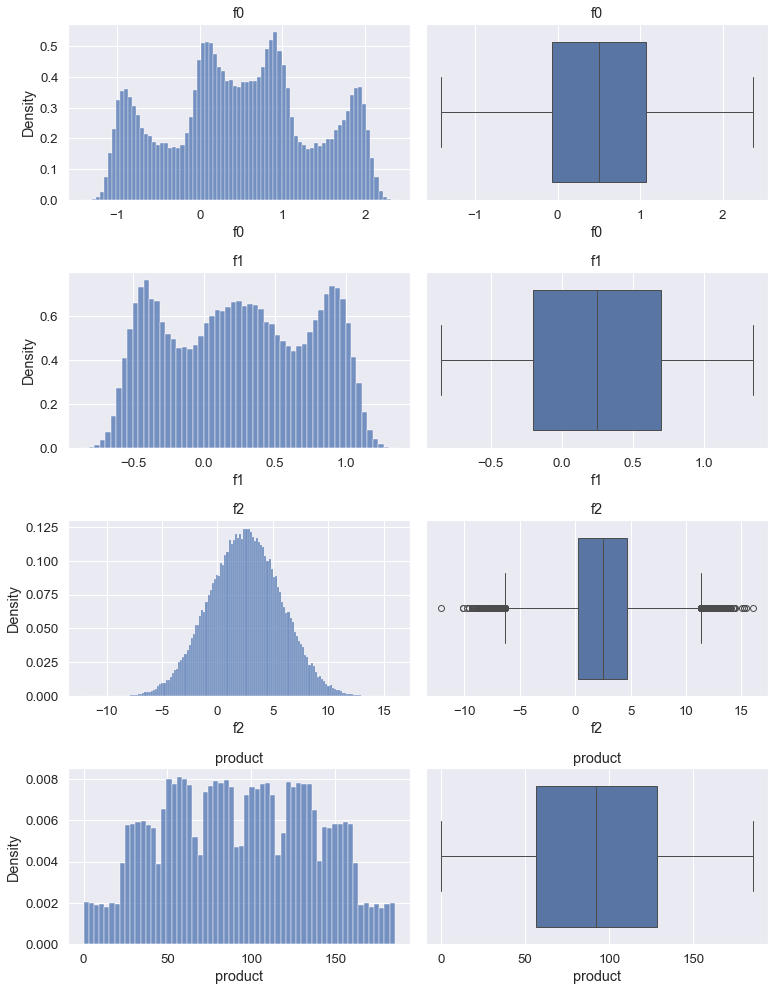

In [56]:
# Первая таблица
numbers_plot(geo_data_0)

На всех гистограммах есть определенная точка на вертикальной оси, которая симметрично разделяет данные. По ящикам с усами выбросов не наблюдается, кроме признака f2. У него есть значения, которые являются выбросами. Определить их границы по графику не удобно, поэтому посчитаем и удалим их

In [57]:
borders(geo_data_0, 'f2')

Нижняя граница выбросов:  -6.353261459618807
Верхняя граница выбросов:  11.356097500771284


Удалим значения в f2, которые больше 11.36 и меньше -6.35

In [58]:
geo_data_0 = geo_data_0[(geo_data_0['f2'] <= 11.36) & (geo_data_0['f2'] >= -6.35)].reset_index(drop=True)
display(geo_data_0)
print(100000 - len(geo_data_0))

,f0,f1,f2,product
0,0.705745,-0.497822,1.221170,105.280060
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265648
3,-0.032172,0.139033,2.978566,168.620773
4,1.988431,0.155413,4.751769,154.036652
...,...,...,...,...
99488,0.971957,0.370953,6.075346,110.744026
99489,1.392429,-0.382606,1.273912,122.346840
99490,1.029585,0.018787,-1.348308,64.375443
99491,0.998163,-0.528582,1.583869,74.040764


507


С этой таблицей на этом все. Мы удалили 507 выбросов в столбце с f2

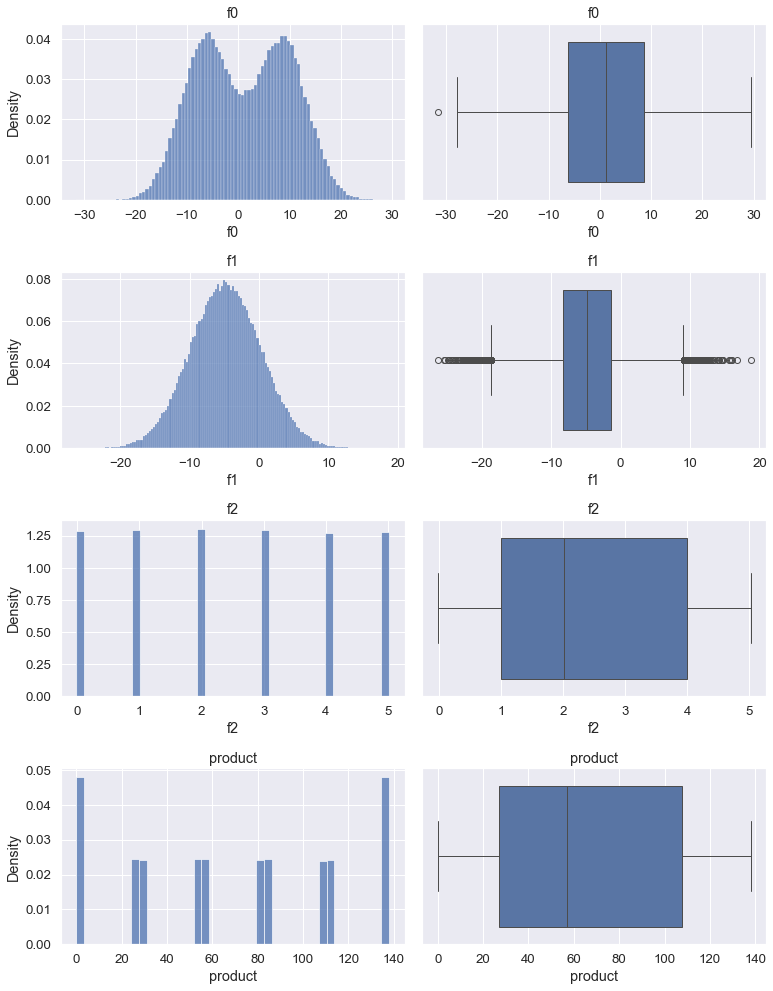

In [59]:
# Вторая таблица
numbers_plot(geo_data_1)

Первые два признака похожи с прошлой таблицей, но у столбца f0 есть один выброс около -34. У f1 много выбросов с двух сторон, как и в прошлый раз найдем границы для выбросов и удалим их. А вот последние две гистограммы выглядят странно. Это происходит из-за того, что значения очень близки к 0, 1, 2, 3, 4 или 5, но они не целые, поэтому уникальных значений очень много. Выбросов у f2 и product нет.

 Найдем и удалим один выброс в f0

In [60]:
geo_data_1 = geo_data_1[geo_data_1['f0'] >= -30]
geo_data_1

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953260
vyE1P,6.263187,-5.948386,5.001160,134.766312
KcrkZ,-13.081196,-11.506057,4.999415,137.945404
AHL4O,12.702195,-8.147433,5.004363,134.766312
...,...,...,...,...
QywKC,9.535638,-6.878139,1.998296,53.906521
ptvty,-10.160631,-12.558096,5.005580,137.945404
09gWa,-7.378891,-3.084104,4.998651,137.945404


Как мы и думали оказался один выброс, который мы и удалили. Осталось разобраться с f1

In [61]:
borders(geo_data_1, 'f1')

Нижняя граница выбросов:  -18.67083978652954
Верхняя граница выбросов:  9.06995153427124


In [62]:
geo_data_1 = geo_data_1[(geo_data_1['f1'] <= 9.07) & (geo_data_1['f1'] >= -18.67)].reset_index(drop=True)
display(geo_data_1)
print(100000 - len(geo_data_1))

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953260
2,6.263187,-5.948386,5.001160,134.766312
3,-13.081196,-11.506057,4.999415,137.945404
4,12.702195,-8.147433,5.004363,134.766312
...,...,...,...,...
99358,9.535638,-6.878139,1.998296,53.906521
99359,-10.160631,-12.558096,5.005580,137.945404
99360,-7.378891,-3.084104,4.998651,137.945404
99361,0.665714,-6.152593,1.000146,30.132364


637


637 выбросов, которые мы удалили из таблицы geo_data_1. Остается последняя - geo_data_2

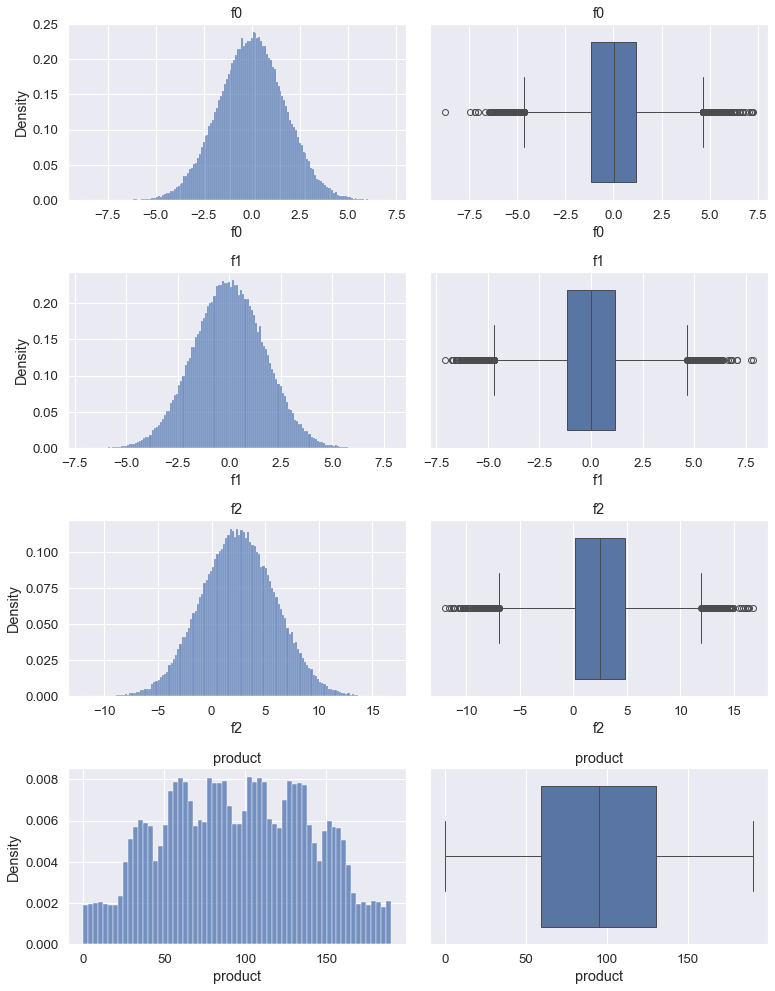

In [63]:
# Третья таблица
numbers_plot(geo_data_2)

Во всех признаках есть выбросы, кроме product. Это нужно исправлять, поэтому добавим выбросы в product)). Шутка


In [64]:
borders(geo_data_2, 'f0')

Нижняя граница выбросов:  -4.643524304032326
Верхняя граница выбросов:  4.639771208167076


In [65]:
geo_data_2 = geo_data_2[(geo_data_2['f0'] <= 4.64) & (geo_data_2['f0'] >= -4.64)].reset_index(drop=True)
display(geo_data_2)
print(100000 - len(geo_data_2))

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530186,56.069698
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572845
4,-0.515993,1.716266,5.899012,149.600739
...,...,...,...,...
99261,-1.777037,1.125220,6.263374,172.327042
99262,-1.261523,-0.894828,2.524545,138.748840
99263,-1.199934,-2.957637,5.219411,157.080078
99264,-2.419896,2.417221,-5.548444,51.795254


734


In [66]:
borders(geo_data_2, 'f1')
geo_data_2 = geo_data_2[(geo_data_2['f1'] <= 4.68) & (geo_data_2['f1'] >= -4.67)].reset_index(drop=True)
display(geo_data_2)
print(100000 - len(geo_data_2))

Нижняя граница выбросов:  -4.681761473417282
Верхняя граница выбросов:  4.671137124300003


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530186,56.069698
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572845
4,-0.515993,1.716266,5.899012,149.600739
...,...,...,...,...
98577,-1.777037,1.125220,6.263374,172.327042
98578,-1.261523,-0.894828,2.524545,138.748840
98579,-1.199934,-2.957637,5.219411,157.080078
98580,-2.419896,2.417221,-5.548444,51.795254


1418


In [67]:
borders(geo_data_2, 'f2')
geo_data_2 = geo_data_2[(geo_data_2['f2'] <= 11.95) & (geo_data_2['f2'] >= -6.96)].reset_index(drop=True)
display(geo_data_2)
print(100000 - len(geo_data_2))

Нижняя граница выбросов:  -6.963412959128618
Верхняя граница выбросов:  11.948306869715452


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530186,56.069698
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572845
4,-0.515993,1.716266,5.899012,149.600739
...,...,...,...,...
97995,-1.777037,1.125220,6.263374,172.327042
97996,-1.261523,-0.894828,2.524545,138.748840
97997,-1.199934,-2.957637,5.219411,157.080078
97998,-2.419896,2.417221,-5.548444,51.795254


2000


29948 выбросов мы удалили в последней таблице. Из них 734 - f0, 684 - f1, 582 - f2

На данном "подшаге" мы провели исследовательский анализ, в котором во всех трех таблицах оказались выбросы. В geo_data_0 мы удалили 507 выбросов в столбце с f2. 637 выбросов мы удалили из таблицы geo_data_1. 636 из них находились в f1, а еще один в f0. И в geo_data_2 нашлось 29948 выбросов. Из них 734 - f0, 684 - f1, 582 - f2.

Подведем итог всего объемного шага 6 "Загрузка и подготовка данных". Сначала мы загрузили данные, это были три таблицы: geo_data_0, geo_data_1, geo_data_2. На первый вгляд ничего особенного не было замечено. Затем мы приступили к предобработке данных, где мы обработали данные, используя две функции: optimize_memory_usage() и analiz(). Первая помогла уменьшить затртату памяти на данные, поменяв типы float64 на float32, чтобы ускорить работу с ними. Вторая - проверила таблицы на пропуски и дубликаты. Ничего из этого не было обнаружено. Затем мы перенесли столбец id в индексы и проверили на дубликаты, но их не оказалось. И последним "подшагом" был исследовательский анализ, в котором во всех трех таблицах оказались выбросы. В geo_data_0 мы удалили 507 выбросов в столбце с f2. 637 выбросов мы удалили из таблицы geo_data_1. 636 из них находились в f1, а еще один в f0. И в geo_data_2 нашлось 29948 выбросов. Из них 734 - f0, 684 - f1, 582 - f2.

## Обучение и проверка модели

По указанию заказчика нужно обучить модель линейной регрессии. Обучающую и валидационную выборки разделим в соотношении 75 к 25. Так как нам нужно обучить три модели из-за трех регионов, то будем использовать функцию model(). Результаты сохраним после каждого вызова функции

In [68]:
predict_0, predict_0_mean, rmse_0, error_0, y_test_0 = model(geo_data_0)

Среднее предикта:  92.59796
Метрика RMSE:  37.395252
Процент разброса ошибки:  40.3845307736673


c:\users\zebra\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Линейная модель получилась явно не идеальной по результатам, но и не сказать, что плохой, т.к. метрика RMSE = 37 в сравнении со средним значением предсказаний = 93 не такая и высокая. Давайте посмотрим, что получится в двух других таблицах

In [69]:
predict_1, predict_1_mean, rmse_1, error_1, y_test_1 = model(geo_data_1)

Среднее предикта:  68.96191
Метрика RMSE:  0.8880475
Процент разброса ошибки:  1.2877363203515886


c:\users\zebra\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Результат на данной таблице получился отличным. Метрика RMSE = 0.89, а Среднее предикта = 68.96. Это означает, что модель имеет очень маленькую разницу между предсказанными и истиными значениями

Остается обучить и узнать результаты последней таблицы

In [70]:
predict_2, predict_2_mean, rmse_2, error_2, y_test_2 = model(geo_data_2)

Среднее предикта:  94.8697
Метрика RMSE:  40.233105
Процент разброса ошибки:  42.408804640475196


c:\users\zebra\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Что-то похожее мы уже видели, когда обучили первую модель. У geo_data_2 оказались такие значения: RMSE = 40.23, среднее предикта = 94.87.

Вот и подошел к концу очередной шаг. В нем мы воспользовались функцией model(), которая обучает модель линейной регрессии, считает среднее предсказанных значений, метрику RMSE и процент разброса полученной величины от среднего предсказанного значения. Результаты первого и третьего регионов оказались не очень хорошими и достаточно схожими. Во втором регионе значение ошибки оказалось очень маленьким. Будет хорошо, если второй регион окажется прибыльной скважиной

## Подготовка к расчёту прибыли

Для того чтобы произвести расчет прибыли, нужно узнать какие объемы запасов есть в потенциальных скважинах. Нам дали  информацию, что один баррель сырья приносит 450 рублей дохода, а на разработку скважин в регионе выделили бюджет — 10 млрд рублей. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших. Поэтому нужно рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. Не забываем, что у нас столбец product измеряется в тыс.баррелей.

In [71]:
# Рассчитаем кол-во баррелей,которое нужно, чтобы заработать 10 млрд рублей или больше
okyp_bar = 10**10 / 450000
okyp_bar

22222.222222222223

22 222.22 баррелей нужно добыть из 200 скважин, чтобы они окупились. Но у нас сырье измеряется в целых числах, поэтому нужно округлить наше число в чуть большую сторону. Получается - 22 223 барреля. Чтобы получить примерное значение для одной скважины, нужно поделить это число на 200

In [72]:
average_bar = 22223 / 200
average_bar = round(average_bar)

Получается, что нужно примерно с каждой скважины 111 тысяч баррелей. Сравним это значение со средними значениями product, предсказанными для каждого региона моделями

In [73]:
print(f'Среднее предсказанное в первом регионе: {predict_0_mean}, а нужно около: {average_bar}. Разница значений: {average_bar -predict_0_mean}')
print(f'Среднее предсказанное во втором регионе: {predict_1_mean}, а нужно около: {average_bar}. Разница значений: {average_bar -predict_1_mean}')
print(f'Среднее предсказанное в третьем регионе: {predict_2_mean}, а нужно около: {average_bar}. Разница значений: {average_bar -predict_2_mean}')

Среднее предсказанное в первом регионе: 92.59796142578125, а нужно около: 111. Разница значений: 18.40203857421875
Среднее предсказанное во втором регионе: 68.96190643310547, а нужно около: 111. Разница значений: 42.03809356689453
Среднее предсказанное в третьем регионе: 94.86969757080078, а нужно около: 111. Разница значений: 16.13030242919922


В первом и третьем регионах разница между средними предсказанными и необходимым для получения прибыли при установке скважин значениями кол-ва тысячей баррелей достаточно мала (16-18 тыс баррелей) по сравнению со вторым регионом (42 тыс баррелей). По таким данным можно сделать вывод, что первый и третий регионы скорее всего будут окупаться, если из 500 случайных точек будут выбирать 200 самых прибыльных. Со вторым регионом это будет происходить реже, т.к. разница достаточно большая.

В подготовке прибыли к расчету мы выяснили, что при выборе 200 максимально прибыльных точек для бурения скважин из 500 случайных, первый и третий регионы скорее всего будут окупаться, а второй намного реже. Это можно было понять по разнице между средними предсказанными и необходимым для получения прибыли при установке скважин значениями кол-ва тысячей баррелей. Значения получились такими: 18 для первой, 42 для второй и 16 для третьей. 

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона. Для этого нам нужно объединить для трех регионов предсказания на тестовой выборке и ее саму. Затем создаем массив датафреймов по 500 случайных предсказанных значений с помощью Bootstrap из 1000 выборок. и с помощью функции profit считаем прибыль по 200 лучшим тестовым значениям массива. Останется только посчитать 95%-й доверительный интервал и  риск убытков

Начнем с объединения тестовой выборки и предсказанных значений в одну таблицу. Посмотрим на них пока отдельно. Для объединения нужно будет predict_0 переделать в датафрейм.

In [74]:
predict_0 = pd.DataFrame(predict_0)
display(predict_0)
display(y_test_0)

,0
0,70.465401
1,106.623650
2,105.209633
3,78.424698
4,79.220215
...,...
24869,102.762787
24870,117.338562
24871,86.229019
24872,115.912849


46085     86.102676
92047     99.631142
43550    113.096054
83156    108.741447
60983     53.908081
            ...    
25043     46.058392
47810     31.449265
38331     48.171085
41958    130.084976
7149      76.862885
Name: product, Length: 24874, dtype: float32

После обучения моделей мы не изменяли переменные predict_0 и y_test_0, поэтому их значения будут соответствовать друг другу. Переделаем y_test_0 в датафрейм и обновим его индексы

In [75]:
y_test_0 = pd.DataFrame(y_test_0)
y_test_0.reset_index(inplace=True, drop=True)
y_test_0

,product
0,86.102676
1,99.631142
2,113.096054
3,108.741447
4,53.908081
...,...
24869,46.058392
24870,31.449265
24871,48.171085
24872,130.084976


Объединяем

In [76]:
pred_test_0 = predict_0.merge(y_test_0, left_index=True, right_index=True)
pred_test_0.columns = ['predict_0', 'y_test_0']
pred_test_0

,predict_0,y_test_0
0,70.465401,86.102676
1,106.623650,99.631142
2,105.209633,113.096054
3,78.424698,108.741447
4,79.220215,53.908081
...,...,...
24869,102.762787,46.058392
24870,117.338562,31.449265
24871,86.229019,48.171085
24872,115.912849,130.084976


Повторим для второго и третьего регионов

In [77]:
predict_1 = pd.DataFrame(predict_1)
y_test_1 = pd.DataFrame(y_test_1)
y_test_1.reset_index(inplace=True, drop=True)
pred_test_1 = predict_1.merge(y_test_1, left_index=True, right_index=True)
pred_test_1.columns = ['predict_1', 'y_test_1']
pred_test_1

,predict_1,y_test_1
0,110.580917,110.992149
1,57.335098,57.085625
2,2.721462,3.179103
3,108.409271,107.813042
4,53.770519,53.906521
...,...,...
24836,55.838150,57.085625
24837,57.414574,57.085625
24838,30.247604,30.132364
24839,26.690371,26.953260


In [78]:
predict_2 = pd.DataFrame(predict_2)
y_test_2 = pd.DataFrame(y_test_2)
y_test_2.reset_index(inplace=True, drop=True)
pred_test_2 = predict_2.merge(y_test_2, left_index=True, right_index=True)
pred_test_2.columns = ['predict_2', 'y_test_2']
pred_test_2

,predict_2,y_test_2
0,91.162285,100.127357
1,103.089539,125.553917
2,118.556763,141.241531
3,91.042274,60.086472
4,82.088966,150.626938
...,...,...
24495,77.609680,70.804581
24496,72.703499,88.376152
24497,95.710617,81.352753
24498,117.819565,136.929550


Узнаем значение параметра frac, чтобы создавались массивы из 500 значений

In [79]:
500 / len(predict_0)

0.020101310605451474

создаем массив из 1000 датафреймов, в которых по 500 случайных значений 

In [80]:
values = []
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = pred_test_0.sample(frac=0.02, replace=True, random_state=state)
    values.append(subsample)
display(values[:3])

[        predict_0    y_test_0
 20962  101.132912  154.664566
 11749  131.792313   72.643135
 2177   103.490936  107.240341
 19876   93.581039   65.682404
 11689   80.740662   47.710674
 ...           ...         ...
 22029   94.535431   28.827080
 13517  128.579315  130.891937
 17127  104.781975  112.682167
 341    106.382988  122.392838
 3949   103.569687   81.409218
 
 [497 rows x 2 columns],
         predict_0    y_test_0
 14684  146.883179  135.376602
 21731   72.028809  104.945084
 582     95.826897   96.428032
 20600   68.727661   14.877374
 5717    43.741604   34.789635
 ...           ...         ...
 10328   74.674950   59.250145
 533    159.915527  145.539536
 19361   75.283035   46.869755
 5265   115.694489   72.417313
 1551    99.694656  119.259895
 
 [497 rows x 2 columns],
         predict_0    y_test_0
 693    109.100105  151.757751
 23496  125.570038  156.967865
 16084   87.587418  124.404617
 13724   82.534805   38.436989
 21854   99.449211   97.096519
 ...           .

И теперь создаем массив profits, в котором с помощью функции profit будем хранить прибыль лучших 200 значений каждого датафрейма из массива values

In [81]:
profits = []
for i in range(1000):
    money = profit(values[i], 'predict_0', 'y_test_0' )
    profits.append(money)
display(profits[:3])

[0.17030585937500042, 0.3301894531249996, 0.8433318359374997]

Считаем 95%-й доверительный интервал и риск убытков

In [82]:
profits = pd.Series(profits)
lower = profits.quantile(0.025).round(2)
upper = profits.quantile(0.975).round(2)
print(lower)
print(upper)
print()

q = (((profits < 0).mean())*100).round(1)
print('Процент убытков: ', q, '%')

-0.09
0.94

Процент убытков:  5.4 %


Из 1000 значений оказались 54 убыточных. Это 5.4%, что не удовлетворяет условиям заказчика. Этот регион нам не подходит. Посмотрим на другие

In [83]:
values = []
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = pred_test_1.sample(frac=0.02, replace=True, random_state=state)
    values.append(subsample)
display(values[:3])

[        predict_1    y_test_1
 20962   81.164848   80.859779
 11749   -0.736720    0.000000
 2177    -1.303916    0.000000
 19876   80.266472   80.859779
 11689   81.671532   80.859779
 ...           ...         ...
 13517   81.187866   80.859779
 17127  138.019165  137.945404
 341    110.190254  110.992149
 3949   107.971375  107.813042
 14684   80.730888   80.859779
 
 [497 rows x 2 columns],
         predict_1    y_test_1
 21731  109.652580  110.992149
 582     81.614143   80.859779
 20600   30.637224   30.132364
 5717    27.524693   26.953260
 18761  137.504700  137.945404
 ...           ...         ...
 19361   31.873186   30.132364
 5265    27.195671   26.953260
 1551   138.903351  137.945404
 693     82.440865   84.038887
 23496  108.516296  107.813042
 
 [497 rows x 2 columns],
         predict_1    y_test_1
 16084  135.003174  134.766312
 13724    1.924183    3.179103
 21854  109.061768  110.992149
 13447   29.346067   30.132364
 7665   137.573425  137.945404
 ...           .

In [84]:
profits = []
for i in range(1000):
    money = profit(values[i], 'predict_1', 'y_test_1' )
    profits.append(money)
display(profits[:3])

[0.2879782226562497, 0.23442294921875018, 0.8622687500000001]

In [85]:
profits = pd.Series(profits)
lower = profits.quantile(0.025)
upper = profits.quantile(0.975)
print(lower)
print(upper)
print()

q = (((profits < 0).mean())*100).round(1)
print('Процент убытков: ', q, '%')

0.040359570312499926
0.8302008227539067

Процент убытков:  1.5 %


А вот тут у нас получилась возможность убытка 1.5%. Это меньше 2.5, поэтому второй регион подходит под условия. Посмотрим на последний регион

In [86]:
values = []
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = pred_test_2.sample(frac=0.02, replace=True, random_state=state)
    values.append(subsample)
display(values[:3])

[        predict_2    y_test_2
 20962   97.395523   73.697807
 11749   79.914406  167.209351
 2177    58.323830   76.560219
 19876   69.593269   85.443687
 11689   83.586372   87.471375
 ...           ...         ...
 22029  104.950912  171.095215
 13517   73.586411   69.997910
 17127  103.801613   81.346252
 341     98.522247  102.361412
 3949   115.616478  154.292419
 
 [490 rows x 2 columns],
         predict_2    y_test_2
 14684   80.714806  103.514580
 21731   90.851707   11.683822
 582     90.697365  163.597305
 20600   71.171234   26.395811
 5717    84.792435   54.034000
 ...           ...         ...
 533     85.500763  151.816040
 19361   97.316437  138.514984
 5265   125.356567  105.242996
 1551   109.406967  179.105927
 693     96.010239  115.903290
 
 [490 rows x 2 columns],
         predict_2    y_test_2
 23496   87.185577   27.980444
 16084   92.478592  102.761894
 13724   67.612007  105.964828
 21854  131.104507  153.366318
 13447  123.653786   45.263725
 ...           .

In [87]:
profits = []
for i in range(1000):
    money = profit(values[i], 'predict_2', 'y_test_2' )
    profits.append(money)
display(profits[:3])

[0.3457707031249999, 0.1103468749999994, 0.38973007812499993]

In [88]:
profits = pd.Series(profits)
lower = profits.quantile(0.025)
upper = profits.quantile(0.975)
print(lower)
print(upper)
print()

q = (((profits < 0).mean())*100).round(1)
print('Процент убытков: ', q, '%')

-0.22733956298828054
0.7980232958984368

Процент убытков:  13.6 %


Из 1000 значений 136 оказались убыточными. Это 13.6%, что не удовлетворяет условиям заказчика

На последнем шаге мы посчитали риски и прибыль бурения новых скважин для каждого региона. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. У нас таким оказался только один регион: geo_data_1, поэтому не нужно даже выбирать по другим показателям. Шанс убытка при бурении новой скважины оказался 1.5%

# Вывод

В данном проекте мы помогли нашей компании «ГлавРосГосНефть», которая предоставила пробы нефти в трёх регионах, с выбором места для бурения новой скважины. Для этого нам пришлось проделать несколько шагов:
- Загрузка и подготовка данных. Сначала мы загрузили данные, это были три таблицы: geo_data_0, geo_data_1, geo_data_2. На первый вгляд ничего особенного не было замечено. Затем мы приступили к предобработке данных, где мы обработали данные, используя две функции: optimize_memory_usage() и analiz(). Первая помогла уменьшить затртату памяти на данные, поменяв типы float64 на float32, чтобы ускорить работу с ними. Вторая - проверила таблицы на пропуски и дубликаты. Ничего из этого не было обнаружено. Затем мы перенесли столбец id в индексы и проверили на дубликаты, но их не оказалось. И последним "подшагом" был исследовательский анализ, в котором во всех трех таблицах оказались выбросы. В geo_data_0 мы удалили 507 выбросов в столбце с f2. 637 выбросов мы удалили из таблицы geo_data_1. 636 из них находились в f1, а еще один в f0. И в geo_data_2 нашлось 29948 выбросов. Из них 734 - f0, 684 - f1, 582 - f2.
- Обучение и проверка модели. На данном шаге мы воспользовались функцией model(), которая обучает модель линейной регрессии, считает среднее предсказанных значений, метрику RMSE и процент разброса полученной величины от среднего предсказанного значения. Результаты первого и третьего регионов оказались не очень хорошими и достаточно схожими(Метрика RMSE для первого:  37.395252 и 40.233105 для второго. Во втором регионе значение ошибки оказалось очень маленьким метрика - 0.8880475.
- Подготовка к расчёту прибыли. Этот шаг нам помог выяснить, что при выборе 200 максимально прибыльных точек для бурения скважин из 500 случайных, первый и третий регионы скорее всего будут окупаться, а второй намного реже. Это можно было понять по разнице между средними предсказанными и необходимым для получения прибыли при установке скважин значениями кол-ва тысячей баррелей. Значения получились такими: 18 для первой, 42 для второй и 16 для третьей.
- Расчёт прибыли и рисков. В нем мы посчитали риски и прибыль бурения новых скважин для каждого региона. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. У нас таким оказался только один регион: geo_data_1, поэтому не нужно даже выбирать по другим показателям. Шанс убытка при бурении новой скважины оказался 1.5%

Самым оптимальным для бурения новых скважин оказался второй регион с данными из geo_data_1. Он показал лучшие результаты при использовании модели. В подготовке прибыли к расчету регион оказался с самым маленьким значением по среднему кол-ву баррелей в скважинах, но это не помешало в итоговой проверке с помощью Bootstrap и функции profit стать единственным регионом, который смог удовлетворить всем условиям компании.